In [1]:
import Pkg
Pkg.activate()
using FUSE, IMAS, QED, VacuumFields
using LinearAlgebra
using Interact, Plots

  Activating project at `~/.julia/environments/v1.10`
Precompiling FUSE
  ✓ QED
  ✓ IMAS
  ✓ NEO
  ✓ FusionMaterials
  ✓ BoundaryPlasmaModels
  ✓ TGLFNN
  ✓ VacuumFields
  ✓ FUSE
  8 dependencies successfully precompiled in 81 seconds. 685 already precompiled.


WebIO._IJuliaInit()

In [2]:
dd, ini, act = FUSE.init(:ITER, init_from=:ods);
FUSE.ActorPassiveStructures(dd, act); # initialize passive coils
FUSE.ActorEquilibrium(dd, act; ip_from=:pulse_schedule); # initialize active coil currents

actors: HCD
actors:  SimpleEC
actors:  SimpleIC
actors:  SimpleLH
actors:  SimpleNB
actors:  SimplePellet
actors: Current
actors:  SteadyStateCurrent
actors: CXbuild
actors: PassiveStructures
actors: Equilibrium
actors:  TEQUILA


In [3]:
active_coils = VacuumFields.MultiCoils(dd)[1:end-2];
passive_coils = VacuumFields.QuadCoil[]
for loop in dd.pf_passive.loop
    for element in loop.element
        outline = element.geometry.outline
        @assert length(outline.r) == 4 "For the time being passive structures must be composed of quadrilateral elements"
        passive_coil = VacuumFields.QuadCoil(outline.r, outline.z)
        passive_coil.resistance = VacuumFields.resistance(passive_coil, loop.resistivity)
        push!(passive_coils, passive_coil)
    end
end
coils = deepcopy(vcat(active_coils, passive_coils));

In [4]:
# COIL ONLY PROPERTIES
Mcc = [VacuumFields.mutual(c1, c2) for c1 in coils, c2 in coils]

# coil current in this model is current per turn
Ic = [VacuumFields.current(c) / VacuumFields.turns(c) for c in coils]
Rc = [VacuumFields.resistance(c) for c in coils];
Vc = zero(Ic);

In [5]:
# PLASMA INDUCTANCES

eqt = dd.equilibrium.time_slice[]
cp1d = dd.core_profiles.profiles_1d[]
Ip = eqt.global_quantities.ip

# COIL MUTUALS
image = VacuumFields.Image(eqt)
Mpc = [VacuumFields.mutual(image, coil, Ip) for coil in coils]
dMpc_dt = zero(Mpc) # How Mpc changes in time (like shape)... to test later

# INTERNAL INDUCTANCE
It = IMAS.cumtrapz(cp1d.grid.area, cp1d.j_tor)
Wp = 0.5 * IMAS.trapz(cp1d.grid.psi, It)
Li = 2 * Wp / Ip^2

# EXTERNAL INDUCTANCE
ψb = eqt.profiles_1d.psi[end]
ψc = sum(Mpc[k] * Ic[k] for k in eachindex(coils))
Le = (ψb - ψc) / Ip
Lp = Li + Le

@show Li, Le, Lp

(Li, Le, Lp) = (3.4468604558619215e-6, 8.499844248417231e-6, 1.1946704704279154e-5)


(3.4468604558619215e-6, 8.499844248417231e-6, 1.1946704704279154e-5)

In [6]:
# COMPUTE RESISTANCE AS P_OHM / (IP * IOHM)
Pohm = dd.core_sources.source[:ohmic].profiles_1d[].electrons.power_inside[end]
Ini = dd.core_profiles.global_quantities.current_non_inductive[]
Iohm = Ip - Ini
Rp = Pohm / (Ip * Iohm)

1.2512400421986712e-9

In [7]:
W0 = QED.Waveform{Float64}(t -> 0.0)
W1 = QED.Waveform{Float64}(t -> -1e3) # VERY STRONG 
#Wramp = QED.Waveform{Float64}(t -> 1e3 * (t < t_ramp ? t/t_ramp : 1.0))
V_waveforms = [k <= 6 ? W1 : W0 for k in eachindex(coils)];

In [8]:
# non_inductive contribution
B0 = eqt.global_quantities.vacuum_toroidal_field.b0
JBni = QED.FE(cp1d.grid.rho_tor_norm, cp1d.j_non_inductive .* B0);

In [9]:
# Initialize
QI = FUSE.qed_init_from_imas(eqt, cp1d; uniform_rho = 101)
#QI.JBni = nothing;
if QI.JBni === nothing
    Vni = 0.0 
else
    Vni = Rp * Ini
end
build = QED.QED_build(Ic, Vc, Rc, Mcc, Vni, Rp, Lp, Mpc, dMpc_dt, V_waveforms);

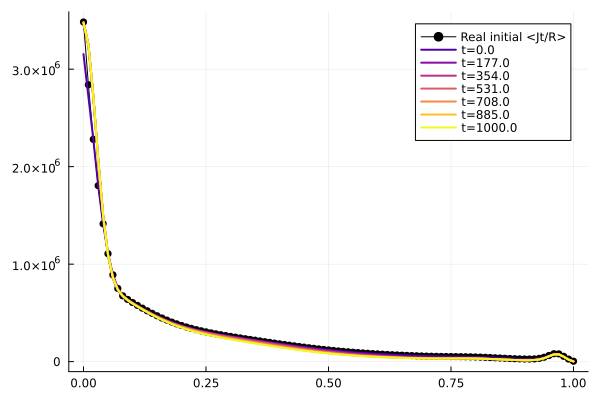

(QED.Ip(QI), QED.Ip(Qd)) = (1.474603539508994e7, 1.1878755255306784e7)


(1.474603539508994e7, 1.1878755255306784e7)

In [10]:
# Plasma only diffusion problem - standard QED

t0 = dd.global_time
t1 = t0 + 1000.0
δt = t1 - t0
No = 1
Ni = 1000
Ip = nothing
Vedge = 0.0
time0 = t0 + δt / 2.0
Qd = QED.diffuse(QI, FUSE.η_imas(dd.core_profiles.profiles_1d[time0]), δt, Ni; Vedge, Ip, debug=true);
@show QED.Ip(QI), QED.Ip(Qd)

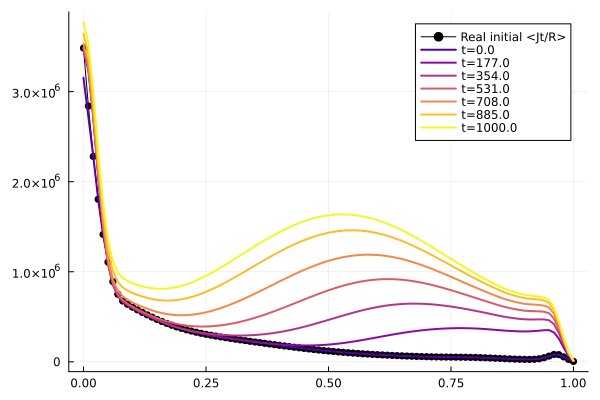

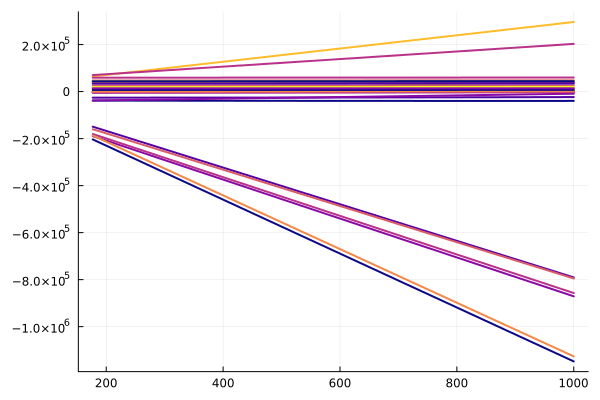

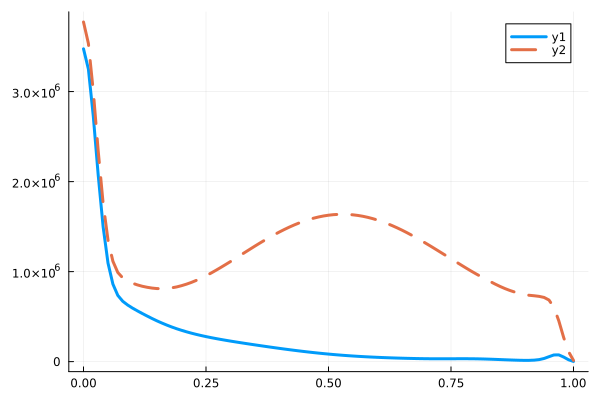

(QED.Ip(QI), QED.Ip(Qd), QED.Ip(Qe)) = (1.474603539508994e7, 1.1878755255306784e7, 1.4466787940979075e8)


(1.474603539508994e7, 1.1878755255306784e7, 1.4466787940979075e8)

In [11]:
# Full coupled evolution
BO = deepcopy(build)
Qe = QED.evolve(deepcopy(QI), FUSE.η_imas(dd.core_profiles.profiles_1d[time0]), BO, δt, Ni; debug=true);
plot(Qd.ρ, QED.Jt_R(Qd), lw=3)
display(plot!(Qe.ρ, QED.Jt_R(Qe), lw=3, ls=:dash))
@show QED.Ip(QI), QED.Ip(Qd), QED.Ip(Qe)

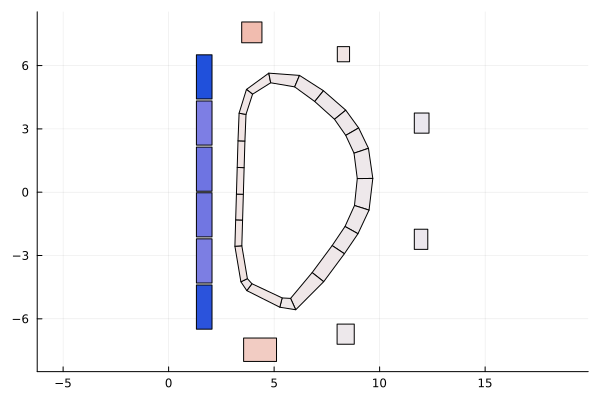

In [12]:
c = cgrad(:diverging)
B = BO
Jmax = maximum(abs.(B.Ic))
p = plot(aspect_ratio=:equal)
for (i,coil) in enumerate(coils)
    current_color_index = (B.Ic[i] + Jmax) / (2 * Jmax)
    plot!(p, coil,color=c[current_color_index], alpha=1.0)
end
display(p)